In [ ]:
import re
import nltk
import string
import spacy
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nltk.download('punkt')
nltk.download('stopwords')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
uploaded = files.upload()

# Initial data exploration


In [ ]:
df_train = pd.read_csv('propaganda_train.tsv', sep='\t')
df_test = pd.read_csv('propaganda_val.tsv', sep='\t')

In [ ]:
# Basic info about dataset
print('======Basic info about dataset========')
print(df_train.info())
print(df_test.info())


======Basic info about dataset========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2414 entries, 0 to 2413
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              2414 non-null   object
 1   tagged_in_context  2414 non-null   object
dtypes: object(2)
memory usage: 37.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              580 non-null    object
 1   tagged_in_context  580 non-null    object
dtypes: object(2)
memory usage: 9.2+ KB
None


In [ ]:
# Descriptive statistics for numerical features
print('======Descriptive statistics  about dataset========')

print(df_train.describe())
print(df_test.describe())

======Descriptive statistics  about dataset========
                 label                                  tagged_in_context
count             2414                                               2414
unique               9                                               2402
top     not_propaganda  <BOS> We know that the Islamic State, al-Qaeda...
freq              1191                                                  2
                 label                                  tagged_in_context
count              580                                                580
unique               9                                                580
top     not_propaganda  We hear again, as we did incessantly from the ...
freq               301                                                  1


In [ ]:
# Check for missing values
print('======Check for missing values========')

print(df_train.isnull().sum())
print(df_test.isnull().sum())

======Check for missing values========
label                0
tagged_in_context    0
dtype: int64
label                0
tagged_in_context    0
dtype: int64


<ipython-input-9-f6201d7c5e53>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


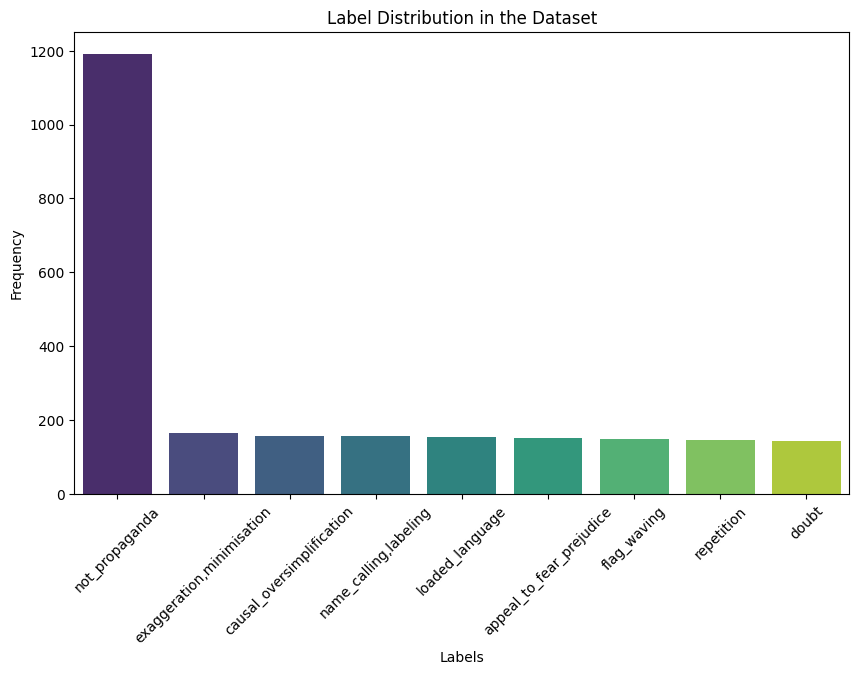

<ipython-input-9-f6201d7c5e53>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


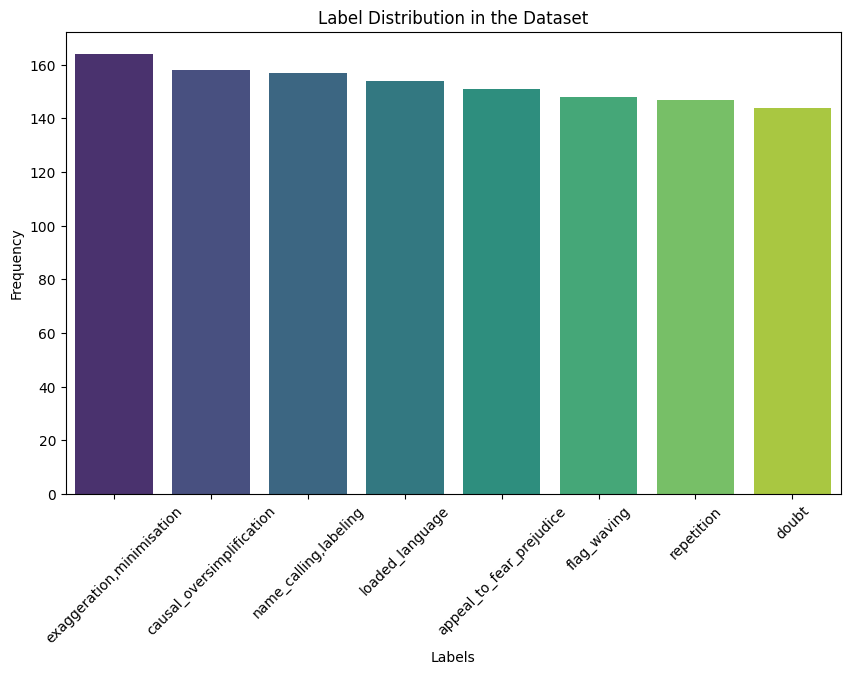

In [ ]:
# Label Distribution
label_counts = df_train['label'].value_counts()

# Text length calculations
df_train['text_length'] = df_train['tagged_in_context'].apply(len)

# Plotting the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Label Distribution in the Dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

df_train = pd.read_csv('propaganda_train.tsv', sep='\t')
# Label Distribution
df_train = df_train[df_train['label'] != 'not_propaganda']
label_counts = df_train['label'].value_counts()
# Text length calculations
df_train['text_length'] = df_train['tagged_in_context'].apply(len)
# Plotting the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Label Distribution in the Dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()



Text-Specific Analysis
1. Text Length Analysis: Calculate the length of the text entries and compare the distributions between propaganda and non-propaganda classes.

    1.1 Purpose: Understand how the length of text varies across different labels.


2. Word Frequency Analysis: Identify the most common words and phrases in each class and overall.
3. Word Clouds: Generate word clouds to visually inspect the most frequent words in each class.

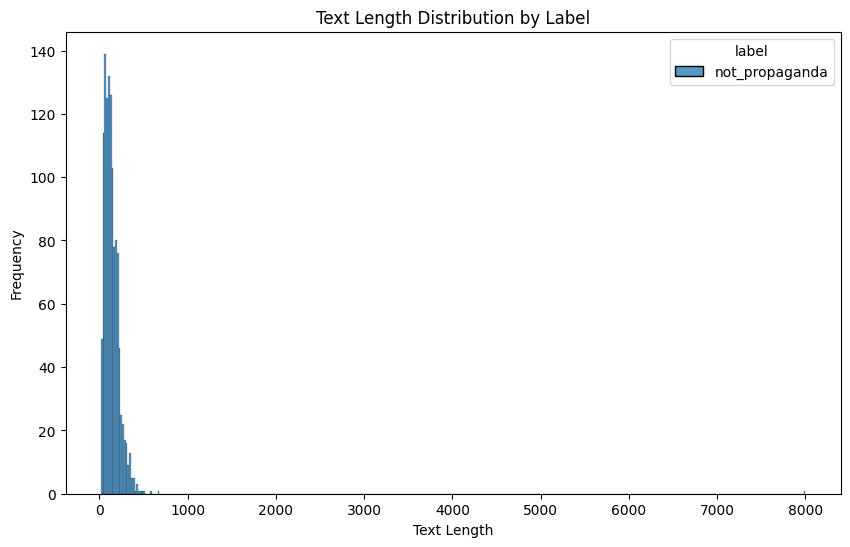

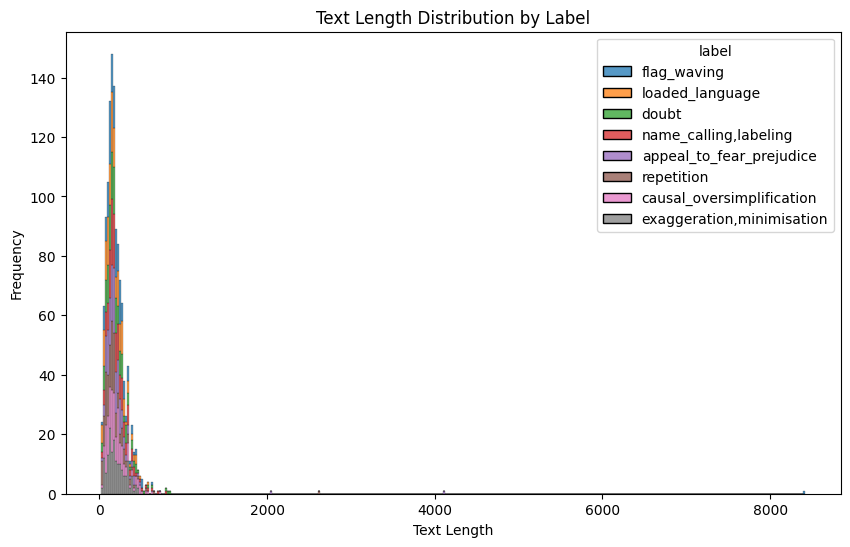

In [ ]:
df_train = pd.read_csv('propaganda_train.tsv', sep='\t')

# Calculate text length
df_train['text_length'] = df_train['tagged_in_context'].apply(len)
df_train = df_train[df_train['label'] == 'not_propaganda']

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(df_train, x='text_length', hue='label', multiple='stack')
plt.title('Text Length Distribution by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

df_train = pd.read_csv('propaganda_train.tsv', sep='\t')
df_train = df_train[df_train['label'] != 'not_propaganda']
# Calculate text length
df_train['text_length'] = df_train['tagged_in_context'].apply(len)

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(df_train, x='text_length', hue='label', multiple='stack')
plt.title('Text Length Distribution by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()



### Insights from the 'not_propaganda' Text Length Distribution

1.The text lengths of 'not_propaganda' samples are tightly clustered around lower values.

2.Low Variability: The majority of 'not_propaganda' texts are relatively short, indicating a possible style or format that these texts commonly follow.

# Word Frequency Analysis

Purpose: Identify the most common words used in each class of texts.


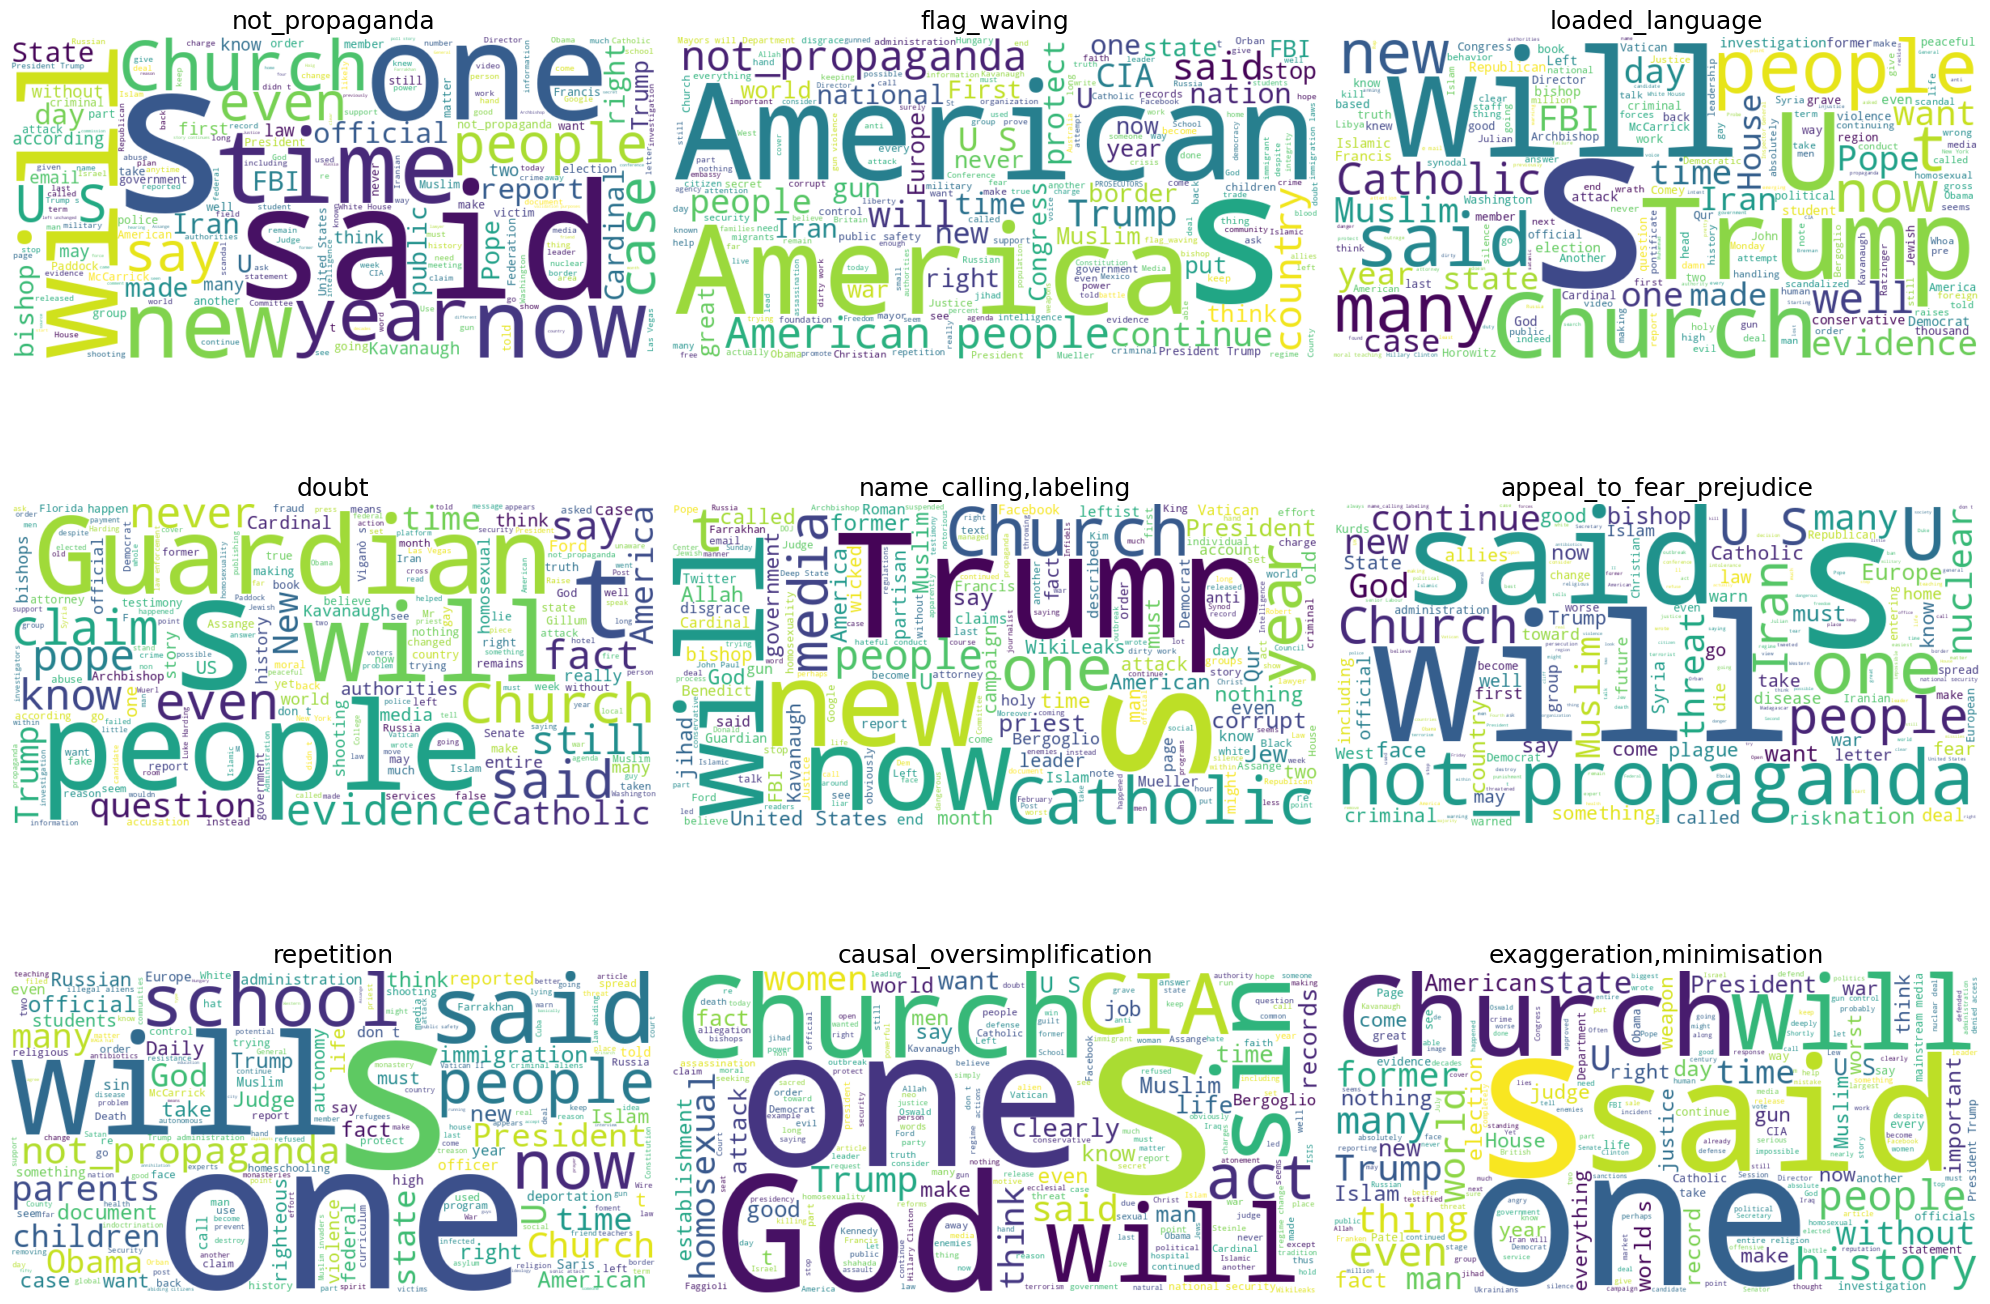

In [ ]:
df_train = pd.read_csv('propaganda_train.tsv', sep='\t')
df_test = pd.read_csv('propaganda_val.tsv', sep='\t')
df_train['text'] = df_train['tagged_in_context'].str.replace('<BOS>|<EOS>', '', regex=True).str.strip()

# Function to generate word clouds for each label
def generate_word_clouds(data, labels):
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()

    for i, label in enumerate(labels):
        # Filter the dataset for the label and concatenate the text
        text = " ".join(data[data['label'] == label]['text'].values)
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        # Plot
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(label, fontsize=18)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Generate word clouds for each label
unique_labels = df_train['label'].unique()
generate_word_clouds(df_train, unique_labels)


In [14]:
df_train = pd.read_csv('propaganda_train.tsv', sep='\t')
# Vectorize words
vectorizer = CountVectorizer(stop_words='english')
df_train['text'] = df_train['tagged_in_context'].str.replace('<BOS>|<EOS>', '', regex=True).str.strip()
word_matrix = vectorizer.fit_transform(df_train['text'])

# Sum up word counts
sum_words = word_matrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Display most common words
print(words_freq[:10])


[('said', 211), ('trump', 183), ('people', 165), ('church', 144), ('president', 98), ('new', 87), ('just', 86), ('time', 83), ('pope', 83), ('american', 81)]


# Experiment1 BoW with different parameter in CountVectorizer

Binary classifier train / test

In [15]:
df_train = pd.read_csv('propaganda_train.tsv', sep='\t')
df_test = pd.read_csv('propaganda_val.tsv', sep='\t')

vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (1,7))

# Fit and transform the extracted spans to a bag-of-words representation
X = vectorizer.fit_transform(df_train['tagged_in_context'])

# Binary labels
binary_label_encoder = LabelEncoder()
y_binary = binary_label_encoder.fit_transform(df_train['label'].apply(lambda x: 0 if x == 'not_propaganda' else 1))

# Split the data
X_train, X_val, y_binary_train, y_binary_val = train_test_split(
    X, y_binary, test_size=0.2, random_state=42)

print("Revised data preparation complete. Features and labels ready for model training.")

# Train binary classifier
binary_classifier = LogisticRegression(random_state=42)
binary_classifier.fit(X_train, y_binary_train)

# Evaluate binary classifier
binary_predictions = binary_classifier.predict(X_val)
binary_classification_report = classification_report(y_binary_val, binary_predictions, output_dict=True)

# binary_classification_report
report_df = pd.DataFrame(binary_classification_report).transpose()
print(report_df)

print('==================================================')
df_test = pd.read_csv('propaganda_val.tsv', sep='\t')

X_test = vectorizer.transform(df_test['tagged_in_context'])

y_binary_test = binary_label_encoder.transform(df_test['label'].apply(lambda x: 0 if x == 'not_propaganda' else 1))

binary_test_predictions = binary_classifier.predict(X_test)

binary_test_classification_report = classification_report(y_binary_test, binary_test_predictions,output_dict=True)

# binary_test_classification_report
binary_test = pd.DataFrame(binary_test_classification_report).transpose()
print(binary_test)

Revised data preparation complete. Features and labels ready for model training.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score    support
0              0.808271  0.892116  0.848126  241.00000
1              0.880184  0.789256  0.832244  242.00000
accuracy       0.840580  0.840580  0.840580    0.84058
macro avg      0.844228  0.840686  0.840185  483.00000
weighted avg   0.844302  0.840580  0.840169  483.00000
              precision    recall  f1-score     support
0              0.833333  0.930233  0.879121  301.000000
1              0.913934  0.799283  0.852772  279.000000
accuracy       0.867241  0.867241  0.867241    0.867241
macro avg      0.873634  0.864758  0.865947  580.000000
weighted avg   0.872105  0.867241  0.866446  580.000000


Multi-class classifier train and test

In [16]:
df_train = pd.read_csv('propaganda_train.tsv', delimiter='\t')
df_train = df_train[df_train['label'] != 'not_propaganda']

df_train['tagged_span'] = [re.search(r'<BOS>(.*?)<EOS>', text).group(1) if '<BOS>' in text and '<EOS>' in text else '' for text in df_train['tagged_in_context']]
#df_train['tagged_span'] = df_train['tagged_span'].apply(preprocess_text)

# Initialize CountVectorizer for bag-of-words model on the extracted spans
vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (1,7), lowercase=True)

# Fit and transform to a bag-of-words representation
X = vectorizer.fit_transform(df_train['tagged_span'])

# Multiclass labels
multiclass_label_encoder = LabelEncoder()
y_multiclass = multiclass_label_encoder.fit_transform(df_train['label'])

# Split the data
X_train, X_val, y_multiclass_train, y_multiclass_val = train_test_split(
    X, y_multiclass, test_size=0.2, random_state=42)

print("Revised data preparation complete. Features and labels ready for model training.")

# Train multiclass classifier
multiclass_classifier = LogisticRegression(random_state=42, multi_class='ovr')
multiclass_classifier.fit(X_train, y_multiclass_train)

# Evaluate
multiclass_predictions = multiclass_classifier.predict(X_val)
multiclass_classification_report = classification_report(y_multiclass_val, multiclass_predictions, target_names=multiclass_label_encoder.classes_,output_dict=True)

# multiclass_classification_report
report_df_m = pd.DataFrame(multiclass_classification_report).transpose()
print(report_df_m)

print("=================================================")

df_test = df_test[df_test['label'] != 'not_propaganda']

#df_test['tagged_span'] = df_test['tagged_in_context'].str.replace('<BOS>|<EOS>', '', regex=True).str.strip()
df_test['tagged_span'] = [re.search(r'<BOS>(.*?)<EOS>', text).group(1) if '<BOS>' in text and '<EOS>' in text else '' for text in df_test['tagged_in_context']]

X_val = vectorizer.transform(df_test['tagged_span'])

y_multiclass = multiclass_label_encoder.transform(df_test['label'])

multiclass_test_predictions = multiclass_classifier.predict(X_val)
multiclass_test_classification_report = classification_report(y_multiclass, multiclass_test_predictions, target_names=multiclass_label_encoder.classes_,output_dict=True)
print("Validation Classification Report:")

# multiclass_classification_report
report_df_m = pd.DataFrame(multiclass_test_classification_report).transpose()
print(report_df_m)


Revised data preparation complete. Features and labels ready for model training.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                           precision    recall  f1-score     support
appeal_to_fear_prejudice    0.521739  0.444444  0.480000   27.000000
causal_oversimplification   0.481481  0.433333  0.456140   30.000000
doubt                       0.538462  0.482759  0.509091   29.000000
exaggeration,minimisation   0.589744  0.621622  0.605263   37.000000
flag_waving                 0.562500  0.750000  0.642857   24.000000
loaded_language             0.406250  0.406250  0.406250   32.000000
name_calling,labeling       0.517241  0.441176  0.476190   34.000000
repetition                  0.486486  0.562500  0.521739   32.000000
accuracy                    0.514286  0.514286  0.514286    0.514286
macro avg                   0.512988  0.517761  0.512191  245.000000
weighted avg                0.512739  0.514286  0.510683  245.000000


<ipython-input-16-fd2311fac50b>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['tagged_span'] = [re.search(r'<BOS>(.*?)<EOS>', text).group(1) if '<BOS>' in text and '<EOS>' in text else '' for text in df_test['tagged_in_context']]


Validation Classification Report:
                           precision    recall  f1-score     support
appeal_to_fear_prejudice    0.562500  0.418605  0.480000   43.000000
causal_oversimplification   0.428571  0.483871  0.454545   31.000000
doubt                       0.484848  0.421053  0.450704   38.000000
exaggeration,minimisation   0.241379  0.250000  0.245614   28.000000
flag_waving                 0.675000  0.692308  0.683544   39.000000
loaded_language             0.439024  0.486486  0.461538   37.000000
name_calling,labeling       0.448276  0.419355  0.433333   31.000000
repetition                  0.375000  0.468750  0.416667   32.000000
accuracy                    0.462366  0.462366  0.462366    0.462366
macro avg                   0.456825  0.455053  0.453243  279.000000
weighted avg                0.469970  0.462366  0.463214  279.000000


# Experiment 2 word-pre processing experiments with BoW

In [18]:
df_train = pd.read_csv('propaganda_train.tsv', sep='\t')
df_test = pd.read_csv('propaganda_val.tsv', sep='\t')

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Apply porterStemmer from nltk.stem library
    processed_tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(processed_tokens)

Binary classifier train / test

In [19]:
df_train = pd.read_csv('propaganda_train.tsv', sep='\t')

# apply the stemmer function
df_train['tagged_in_context'] = df_train['tagged_in_context'].apply(preprocess_text)

# Initialize CountVectorizer with optimized parameters
vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (1,7))

# Fit and transform the extracted spans to a bag-of-words representation
X = vectorizer.fit_transform(df_train['tagged_in_context'])

# Binary labels
binary_label_encoder = LabelEncoder()
y_binary = binary_label_encoder.fit_transform(df_train['label'].apply(lambda x: 0 if x == 'not_propaganda' else 1))

# Split the data
X_train, X_val, y_binary_train, y_binary_val = train_test_split(
    X, y_binary, test_size=0.2, random_state=42)

print("Revised data preparation complete. Features and labels ready for model training.")

# Train binary classifier
binary_classifier = LogisticRegression(random_state=42)
binary_classifier.fit(X_train, y_binary_train)

# Evaluate
binary_predictions = binary_classifier.predict(X_val)
binary_classification_report = classification_report(y_binary_val, binary_predictions, output_dict=True)

# binary_classification_report
report_df = pd.DataFrame(binary_classification_report).transpose()
print(report_df)

print('==================================================')
df_test = pd.read_csv('propaganda_val.tsv', sep='\t')
df_test['tagged_in_context'] = df_test['tagged_in_context'].apply(preprocess_text)

X_test = vectorizer.transform(df_test['tagged_in_context'])

y_binary_test = binary_label_encoder.transform(df_test['label'].apply(lambda x: 0 if x == 'not_propaganda' else 1))

binary_test_predictions = binary_classifier.predict(X_test)
binary_test_classification_report = classification_report(y_binary_test, binary_test_predictions,output_dict=True)

# binary_test_classification_report
binary_test = pd.DataFrame(binary_test_classification_report).transpose()
print(binary_test)

Revised data preparation complete. Features and labels ready for model training.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score     support
0              0.806202  0.863071  0.833667  241.000000
1              0.853333  0.793388  0.822270  242.000000
accuracy       0.828157  0.828157  0.828157    0.828157
macro avg      0.829767  0.828229  0.827969  483.000000
weighted avg   0.829816  0.828157  0.827957  483.000000
              precision    recall  f1-score     support
0              0.844237  0.900332  0.871383  301.000000
1              0.884170  0.820789  0.851301  279.000000
accuracy       0.862069  0.862069  0.862069    0.862069
macro avg      0.864203  0.860560  0.861342  580.000000
weighted avg   0.863446  0.862069  0.861723  580.000000


Multiple-class classifier train / test

In [20]:
df_train = pd.read_csv('propaganda_train.tsv', delimiter='\t')
df_train = df_train[df_train['label'] != 'not_propaganda']

# Apply preprocessing to the text column
df_train['tagged_span'] = [re.search(r'<BOS>(.*?)<EOS>', text).group(1) if '<BOS>' in text and '<EOS>' in text else '' for text in df_train['tagged_in_context']]
df_train['tagged_span'] = df_train['tagged_span'].apply(preprocess_text)

# Initialize CountVectorizer for bag-of-words
vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (1,8), lowercase=True)

# Fit and transform to a bag-of-words representation
X = vectorizer.fit_transform(df_train['tagged_span'])

# Multiclass labels
multiclass_label_encoder = LabelEncoder()
y_multiclass = multiclass_label_encoder.fit_transform(df_train['label'])

# Split the data
X_train, X_val, y_multiclass_train, y_multiclass_val = train_test_split(
    X, y_multiclass, test_size=0.2, random_state=42)

print("Revised data preparation complete. Features and labels ready for model training.")

# Train multiclass classifier
multiclass_classifier = LogisticRegression(random_state=42, multi_class='ovr')
multiclass_classifier.fit(X_train, y_multiclass_train)

# Evaluate
multiclass_predictions = multiclass_classifier.predict(X_val)
multiclass_classification_report = classification_report(y_multiclass_val, multiclass_predictions, target_names=multiclass_label_encoder.classes_,output_dict=True)

# multiclass_classification_report
report_df_m = pd.DataFrame(multiclass_classification_report).transpose()
print(report_df_m)

print("=================================================")
df_test = pd.read_csv('propaganda_val.tsv', sep='\t')
df_test = df_test[df_test['label'] != 'not_propaganda']

#df_test['tagged_span'] = df_test['tagged_in_context'].str.replace('<BOS>|<EOS>', '', regex=True).str.strip()
df_test['tagged_span'] = [re.search(r'<BOS>(.*?)<EOS>', text).group(1) if '<BOS>' in text and '<EOS>' in text else '' for text in df_test['tagged_in_context']]
df_test['tagged_span'] = df_test['tagged_span'].apply(preprocess_text)

X_val = vectorizer.transform(df_test['tagged_span'])

y_multiclass = multiclass_label_encoder.transform(df_test['label'])

# Evaluate multiclass classifier
multiclass_test_predictions = multiclass_classifier.predict(X_val)
multiclass_test_classification_report = classification_report(y_multiclass, multiclass_test_predictions, target_names=multiclass_label_encoder.classes_,output_dict=True)
print("Validation Classification Report:")

# multiclass_classification_report
report_df_m = pd.DataFrame(multiclass_test_classification_report).transpose()
print(report_df_m)


Revised data preparation complete. Features and labels ready for model training.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                           precision    recall  f1-score    support
appeal_to_fear_prejudice    0.416667  0.370370  0.392157   27.00000
causal_oversimplification   0.444444  0.400000  0.421053   30.00000
doubt                       0.391304  0.310345  0.346154   29.00000
exaggeration,minimisation   0.500000  0.513514  0.506667   37.00000
flag_waving                 0.531250  0.708333  0.607143   24.00000
loaded_language             0.305556  0.343750  0.323529   32.00000
name_calling,labeling       0.551724  0.470588  0.507937   34.00000
repetition                  0.444444  0.500000  0.470588   32.00000
accuracy                    0.448980  0.448980  0.448980    0.44898
macro avg                   0.448174  0.452113  0.446903  245.00000
weighted avg                0.448734  0.448980  0.445951  245.00000
Validation Classification Report:
                           precision    recall  f1-score     support
appeal_to_fear_prejudice    0.444444  0.372093  0.405063   43.000000
causal_overs

# Experiment 3 : NER with lemmatize for Bow

In [22]:
df_train = pd.read_csv('propaganda_train.tsv', sep='\t')
df_test = pd.read_csv('propaganda_val.tsv', sep='\t')

In [21]:
# Load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")
lemma = WordNetLemmatizer()
def preprocess_text(text):

    # Process the text with spaCy to extract entities
    doc = nlp(text)
    entities = ' '.join([ent.text for ent in doc.ents])
    # Tokenization
    tokens = word_tokenize(text)

    # Apply lemmatization from WordNetLemmatizer from nltk.stem
    processed_tokens = [lemma.lemmatize(token.lower()) for token in tokens if token.lower() not in entities.lower()]

    # Combine processed tokens and entities
    combined_features = ' '.join(processed_tokens) + ' ' + entities

    return combined_features

Binary train test

In [23]:
df_train = pd.read_csv('propaganda_train.tsv', sep='\t')

# apply the function
df_train['tagged_in_context'] = df_train['tagged_in_context'].apply(preprocess_text)

# Initialize CountVectorizer with optimized parameters
vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (1,7))

# Fit and transform to a bag-of-words representation
X = vectorizer.fit_transform(df_train['tagged_in_context'])

# Binary labels
binary_label_encoder = LabelEncoder()
y_binary = binary_label_encoder.fit_transform(df_train['label'].apply(lambda x: 0 if x == 'not_propaganda' else 1))

# Split the data
X_train, X_val, y_binary_train, y_binary_val = train_test_split(
    X, y_binary, test_size=0.2, random_state=42)

print("Revised data preparation complete. Features and labels ready for model training.")

# Train binary classifier
binary_classifier = LogisticRegression(random_state=42)
binary_classifier.fit(X_train, y_binary_train)

# Evaluate
binary_predictions = binary_classifier.predict(X_val)
binary_classification_report = classification_report(y_binary_val, binary_predictions, output_dict=True)

# binary_classification_report
report_df = pd.DataFrame(binary_classification_report).transpose()
print(report_df)

print('==================================================')
df_test = pd.read_csv('propaganda_val.tsv', sep='\t')
df_test['tagged_in_context'] = df_test['tagged_in_context'].apply(preprocess_text)

X_test = vectorizer.transform(df_test['tagged_in_context'])

y_binary_test = binary_label_encoder.transform(df_test['label'].apply(lambda x: 0 if x == 'not_propaganda' else 1))

# Evaluate
binary_test_predictions = binary_classifier.predict(X_test)
binary_test_classification_report = classification_report(y_binary_test, binary_test_predictions,output_dict=True)

# binary_test_classification_report
binary_test = pd.DataFrame(binary_test_classification_report).transpose()
print(binary_test)

Revised data preparation complete. Features and labels ready for model training.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score     support
0              0.795181  0.821577  0.808163  241.000000
1              0.816239  0.789256  0.802521  242.000000
accuracy       0.805383  0.805383  0.805383    0.805383
macro avg      0.805710  0.805416  0.805342  483.000000
weighted avg   0.805732  0.805383  0.805336  483.000000
              precision    recall  f1-score     support
0              0.808050  0.867110  0.836538  301.000000
1              0.844358  0.777778  0.809701  279.000000
accuracy       0.824138  0.824138  0.824138    0.824138
macro avg      0.826204  0.822444  0.823120  580.000000
weighted avg   0.825515  0.824138  0.823629  580.000000


Multiple-class classifier train test

In [24]:
df_train = pd.read_csv('propaganda_train.tsv', delimiter='\t')
df_train = df_train[df_train['label'] != 'not_propaganda']

# Apply preprocessing to the text column
df_train['tagged_span'] = [re.search(r'<BOS>(.*?)<EOS>', text).group(1) if '<BOS>' in text and '<EOS>' in text else '' for text in df_train['tagged_in_context']]
df_train['tagged_span'] = df_train['tagged_span'].apply(preprocess_text)

# Initialize CountVectorizer for bag-of-words model
vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (1,8), lowercase=True)

# Fit and transform to a bag-of-words representation
X = vectorizer.fit_transform(df_train['tagged_span'])

# Multiclass labels
multiclass_label_encoder = LabelEncoder()
y_multiclass = multiclass_label_encoder.fit_transform(df_train['label'])

# Split the data
X_train, X_val, y_multiclass_train, y_multiclass_val = train_test_split(
    X, y_multiclass, test_size=0.2, random_state=42)

print("Revised data preparation complete. Features and labels ready for model training.")

# Train multiclass classifier
multiclass_classifier = LogisticRegression(random_state=42, multi_class='ovr')
multiclass_classifier.fit(X_train, y_multiclass_train)

# Evaluate
multiclass_predictions = multiclass_classifier.predict(X_val)
multiclass_classification_report = classification_report(y_multiclass_val, multiclass_predictions, target_names=multiclass_label_encoder.classes_,output_dict=True)

# multiclass_classification_report
report_df_m = pd.DataFrame(multiclass_classification_report).transpose()
print(report_df_m)

print("=================================================")
df_test = pd.read_csv('propaganda_val.tsv', sep='\t')
df_test = df_test[df_test['label'] != 'not_propaganda']

#df_test['tagged_span'] = df_test['tagged_in_context'].str.replace('<BOS>|<EOS>', '', regex=True).str.strip()
df_test['tagged_span'] = [re.search(r'<BOS>(.*?)<EOS>', text).group(1) if '<BOS>' in text and '<EOS>' in text else '' for text in df_test['tagged_in_context']]
df_test['tagged_span'] = df_test['tagged_span'].apply(preprocess_text)

# Transform to a bag-of-words representation
X_val = vectorizer.transform(df_test['tagged_span'])

y_multiclass = multiclass_label_encoder.transform(df_test['label'])

multiclass_test_predictions = multiclass_classifier.predict(X_val)
multiclass_test_classification_report = classification_report(y_multiclass, multiclass_test_predictions, target_names=multiclass_label_encoder.classes_,output_dict=True)
print("Validation Classification Report:")

# multiclass_classification_report
report_df_m = pd.DataFrame(multiclass_test_classification_report).transpose()
print(report_df_m)


Revised data preparation complete. Features and labels ready for model training.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                           precision    recall  f1-score     support
appeal_to_fear_prejudice    0.500000  0.407407  0.448980   27.000000
causal_oversimplification   0.428571  0.300000  0.352941   30.000000
doubt                       0.387097  0.413793  0.400000   29.000000
exaggeration,minimisation   0.588235  0.540541  0.563380   37.000000
flag_waving                 0.513514  0.791667  0.622951   24.000000
loaded_language             0.363636  0.375000  0.369231   32.000000
name_calling,labeling       0.500000  0.382353  0.433333   34.000000
repetition                  0.414634  0.531250  0.465753   32.000000
accuracy                    0.461224  0.461224  0.461224    0.461224
macro avg                   0.461961  0.467751  0.457071  245.000000
weighted avg                0.463578  0.461224  0.455344  245.000000
Validation Classification Report:
                           precision    recall  f1-score     support
appeal_to_fear_prejudice    0.575758  0.441860  0.500000   43.000000


# Fine-tuning with countervector and LogisticRegression

binary

In [ ]:
# Load data
df_train = pd.read_csv('propaganda_train.tsv', sep='\t')

# Prepare labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train['label'].apply(lambda x: 0 if x == 'not_propaganda' else 1))

analyzers = ['word', 'char', 'char_wb']
ngram_ranges = [(1, 4), (1, 5)]
penalties = ['l1', 'l2']
C_values = [0.01, 0.1, 1]
best_score = 0
best_config = {}

for analyzer in analyzers:
    for ngram_range in ngram_ranges:
        for penalty in penalties:
            if penalty == 'l1':
                solvers = ['saga']  # saga supports l1

            else:
                solvers = ['lbfgs', 'saga']
            for solver in solvers:
                for C in C_values:
                    vectorizer = CountVectorizer(analyzer=analyzer, ngram_range=ngram_range, lowercase=True)
                    X = vectorizer.fit_transform(df_train['tagged_in_context'])

                    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

                    model = LogisticRegression(random_state=42, penalty=penalty, C=C, solver=solver, max_iter=10000)
                    model.fit(X_train, y_train)

                    predictions = model.predict(X_val)
                    report = classification_report(y_val, predictions, output_dict=True, zero_division=0)
                    f1_score = report['weighted avg']['f1-score']

                    if f1_score > best_score:
                        best_score = f1_score
                        best_config = {
                            'analyzer': analyzer,
                            'ngram_range': ngram_range,
                            'penalty': penalty,
                            'C': C,
                            'solver': solver,
                            'f1_score': f1_score
                        }

# Display the best configuration and its F1-score
print(f"Best Configuration: Analyzer={best_config['analyzer']}, Ngram_range={best_config['ngram_range']}, Penalty={best_config['penalty']}, C={best_config['C']}, Solver={best_config['solver']}")
print(f"Best F1-Score: {best_config['f1_score']}")


multiclass

In [ ]:
# Load data
df_train = pd.read_csv('propaganda_train.tsv', delimiter='\t')
df_train = df_train[df_train['label'] != 'not_propaganda']
df_train['tagged_span'] = [re.search(r'<BOS>(.*?)<EOS>', text).group(1) if '<BOS>' in text and '<EOS>' in text else '' for text in df_train['tagged_in_context']]

analyzers = ['char', 'char_wb']
ngram_ranges = [(1, 4), (1, 5)]
penalties = ['l1', 'l2']
C_values = [0.01, 0.1, 1]
best_score = 0
best_config = {}

for analyzer in analyzers:
    for ngram_range in ngram_ranges:
        for penalty in penalties:
            if penalty == 'l1':
                solvers = ['saga']  # saga supports l1

            else:
                solvers = ['lbfgs', 'saga']  # lbfgs and saga support l2

            for solver in solvers:
                for C in C_values:
                    vectorizer = CountVectorizer(analyzer=analyzer, ngram_range=ngram_range, lowercase=True)
                    X = vectorizer.fit_transform(df_train['tagged_span'])
                    multiclass_label_encoder = LabelEncoder()
                    y_multiclass = multiclass_label_encoder.fit_transform(df_train['label'])

                    X_train, X_val, y_train, y_val = train_test_split(X, y_multiclass, test_size=0.2, random_state=42)

                    model = LogisticRegression(random_state=42, penalty=penalty, C=C, solver=solver, max_iter=10000, multi_class='multinomial')
                    model.fit(X_train, y_train)

                    predictions = model.predict(X_val)
                    report = classification_report(y_val, predictions, output_dict=True, zero_division=0)
                    f1_score = report['weighted avg']['f1-score']

                    if f1_score > best_score:
                        best_score = f1_score
                        best_config = {
                            'analyzer': analyzer,
                            'ngram_range': ngram_range,
                            'penalty': penalty,
                            'C': C,
                            'solver': solver,
                            'f1_score': f1_score
                        }

# Display the best configuration and its F1-score
print(f"Best Configuration: Analyzer={best_config['analyzer']}, Ngram_range={best_config['ngram_range']}, Penalty={best_config['penalty']}, C={best_config['C']}, Solver={best_config['solver']}")
print(f"Best F1-Score: {best_config['f1_score']}")

# BERT experiment

In [ ]:
import re
import torch
from tqdm import tqdm
from transformers import AdamW
from google.colab import files
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
use_cuda=torch.cuda.is_available()
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu")

GPU acceleration enabled


In [ ]:
df_train = pd.read_csv('propaganda_train.tsv', sep='\t')
df_test = pd.read_csv('propaganda_val.tsv', sep='\t')

Binary train

In [ ]:
# Remove <BOS> and <EOS> tags
#df_train['text'] = df_train['tagged_in_context'].str.replace('<BOS>|<EOS>', '', regex=True).str.strip()

# transform labels into a binary labeling
df_train['binary_label'] = df_train['label'].apply(lambda x: 0 if x == 'not_propaganda' else 1)

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize the text
tokens = tokenizer.batch_encode_plus(
    df_train['tagged_in_context'].tolist(),
    max_length=256,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='pt')

#Create a DataLoader
dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'], torch.tensor(df_train['binary_label'].tolist()))
data_loader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(3):
    total_loss = 0
    progress_bar = tqdm(data_loader, desc="Epoch {:1d}".format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(data_loader)

    print(f"Average training loss: {avg_train_loss}")

# Save the model to disk
model.save_pretrained('./model_save')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use th

Average training loss: 0.4459767478536691


Average training loss: 0.20780870669971632


Average training loss: 0.10177398695369923


binary test


In [ ]:
model.eval()

# Remove <BOS> and <EOS> tags
#df_test['text'] = df_test['tagged_in_context'].str.replace('<BOS>|<EOS>', '', regex=True).str.strip()

# transform labels into a binary labeling
df_test['binary_label'] = df_test['label'].apply(lambda x: 0 if x == 'not_propaganda' else 1)

# Check the distribution of the corrected binary labels
binary_label_distribution = df_test['binary_label'].value_counts(normalize=True)

# Tokenize the text
n_tokens = tokenizer.batch_encode_plus(
    df_test['tagged_in_context'].tolist(),
    max_length=256,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='pt')

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Prepare inputs
input_ids = n_tokens['input_ids'].to(device)
attention_mask = n_tokens['attention_mask'].to(device)

# No need to track gradients for prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    predictions = outputs.logits.argmax(dim=1)  # Get the predicted class

# Assuming true labels are stored in new_df['label']
true_labels = df_test['binary_label'].tolist()
print("Accuracy:", accuracy_score(true_labels, predictions.tolist()))
print("Classification Report:\n", classification_report(true_labels, predictions.tolist()))



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy: 0.9396551724137931
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       301
           1       0.93      0.94      0.94       279

    accuracy                           0.94       580
   macro avg       0.94      0.94      0.94       580
weighted avg       0.94      0.94      0.94       580



multiclass train

In [ ]:
# Load and clean the training data
df_train = pd.read_csv('propaganda_train.tsv', delimiter='\t')
df_train = df_train[df_train['label'] != 'not_propaganda']
df_train['text'] = [re.search(r'<BOS>(.*?)<EOS>', text).group(1) if '<BOS>' in text and '<EOS>' in text else '' for text in df_train['tagged_in_context']]

# Encoding labels
label_encoder = LabelEncoder()
df_train['encoded_labels'] = label_encoder.fit_transform(df_train['label'])

num_labels = len(label_encoder.classes_)
print("Number of labels:", num_labels)

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

def tokenize_and_encode(texts):
    tokens = tokenizer.batch_encode_plus(
        texts,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return tokens['input_ids'], tokens['attention_mask']

# Tokenizing and encoding the training and validation sets
train_input_ids, train_attention_mask = tokenize_and_encode(df_train['text'].tolist())

# Convert labels to tensors
train_labels = torch.tensor(df_train['encoded_labels'].tolist())

train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.train()

for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Average training loss: {avg_train_loss:.4f}")

# Save the trained model
model.save_pretrained('./model_save')



Number of labels: 8


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training: 100%|██████████| 153/153 [00:52<00:00,  2.90it/s]


Epoch 1: Average training loss: 1.9913


Training: 100%|██████████| 153/153 [00:52<00:00,  2.94it/s]


Epoch 2: Average training loss: 1.6192


Training: 100%|██████████| 153/153 [00:52<00:00,  2.92it/s]


Epoch 3: Average training loss: 1.2210


Multi-test

In [ ]:
df_val = pd.read_csv('propaganda_val.tsv', delimiter='\t')
df_val = df_val[df_val['label'] != 'not_propaganda']
df_val['text'] = [re.search(r'<BOS>(.*?)<EOS>', text).group(1) if '<BOS>' in text and '<EOS>' in text else '' for text in df_val['tagged_in_context']]

# Encoding labels
df_val['encoded_labels'] = label_encoder.transform(df_val['label'])

# Tokenizing and encoding the training and validation sets
val_input_ids, val_attention_mask = tokenize_and_encode(df_val['text'].tolist())

# Convert labels to tensors
val_labels = torch.tensor(df_val['encoded_labels'].tolist())

val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)

# Create data loaders
batch_size = 8
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model.eval()
predictions, true_labels = [], []

for batch in tqdm(val_loader, desc="Evaluating"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, axis=1)
    predictions.extend(predicted_labels.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))



Evaluating: 100%|██████████| 35/35 [00:04<00:00,  8.06it/s]

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.58      0.65      0.62        43
causal_oversimplification       0.54      0.48      0.51        31
                    doubt       0.64      0.74      0.68        38
exaggeration,minimisation       0.44      0.43      0.44        28
              flag_waving       0.70      0.67      0.68        39
          loaded_language       0.54      0.41      0.46        37
    name_calling,labeling       0.72      0.74      0.73        31
               repetition       0.46      0.50      0.48        32

                 accuracy                           0.58       279
                macro avg       0.58      0.58      0.57       279
             weighted avg       0.58      0.58      0.58       279



expriment1 (using dynamic padding) with Binary

In [ ]:
df_train = pd.read_csv('propaganda_train.tsv', delimiter='\t')
df_val = pd.read_csv('propaganda_val.tsv', delimiter='\t')

df_train['binary_label'] = df_train['label'].apply(lambda x: 0 if x == 'not_propaganda' else 1)
df_val['binary_label'] = df_val['label'].apply(lambda x: 0 if x == 'not_propaganda' else 1)

# Tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Custom collate function for dynamic padding
def collate_batch(batch):
    input_ids = [item[0] for item in batch]
    attention_masks = [item[1] for item in batch]
    labels = [item[2] for item in batch]

    input_ids = pad_sequence([torch.tensor(x) for x in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence([torch.tensor(x) for x in attention_masks], batch_first=True, padding_value=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

# Function to tokenize and encode a list of texts
def tokenize_and_encode(texts):
    encoding = tokenizer(
        texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=False,
        truncation=True,
        max_length=256
    )
    return encoding['input_ids'], encoding['attention_mask']

# Prepare the data for training and validation
train_encodings = tokenize_and_encode(df_train['tagged_in_context'].tolist())
train_labels = df_train['binary_label'].tolist()
train_dataset = list(zip(train_encodings[0], train_encodings[1], train_labels))

val_encodings = tokenize_and_encode(df_val['tagged_in_context'].tolist())
val_labels = df_val['binary_label'].tolist()
val_dataset = list(zip(val_encodings[0], val_encodings[1], val_labels))

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, sampler=RandomSampler(train_dataset), collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=collate_batch)

# Training the model
optimizer = AdamW(model.parameters(), lr=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(3):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in tqdm(train_loader, desc="Training"):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Average training loss: {total_loss / len(train_loader):.4f}")

# Save the trained model
model.save_pretrained('./model_save')




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training: 100%|██████████| 302/302 [00:42<00:00,  7.13it/s]


Epoch 1: Average training loss: 0.4179


Training: 100%|██████████| 302/302 [00:41<00:00,  7.22it/s]


Epoch 2: Average training loss: 0.1501


Training: 100%|██████████| 302/302 [00:40<00:00,  7.49it/s]


Epoch 3: Average training loss: 0.0738


In [ ]:
model.eval()
predictions, true_labels = [], []

for batch in tqdm(val_loader, desc="Evaluating"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, axis=1)
    predictions.extend(predicted_labels.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())

print(classification_report(true_labels, predictions))


Evaluating: 100%|██████████| 73/73 [00:02<00:00, 25.29it/s]


              precision    recall  f1-score   support

           0       0.98      0.91      0.94       301
           1       0.91      0.97      0.94       279

    accuracy                           0.94       580
   macro avg       0.94      0.94      0.94       580
weighted avg       0.94      0.94      0.94       580



expriment1 (using dynamic padding) with multi

In [ ]:
# Load and preprocess data
df_train = pd.read_csv('propaganda_train.tsv', delimiter='\t')
df_val = pd.read_csv('propaganda_val.tsv', delimiter='\t')

df_train = df_train[df_train['label'] != 'not_propaganda']
df_val = df_val[df_val['label'] != 'not_propaganda']

df_train['text'] = [re.search(r'<BOS>(.*?)<EOS>', text).group(1) if '<BOS>' in text and '<EOS>' in text else '' for text in df_train['tagged_in_context']]
df_val['text'] = [re.search(r'<BOS>(.*?)<EOS>', text).group(1) if '<BOS>' in text and '<EOS>' in text else '' for text in df_val['tagged_in_context']]

label_encoder = LabelEncoder()
df_train['encoded_labels'] = label_encoder.fit_transform(df_train['label'])
df_val['encoded_labels'] = label_encoder.transform(df_val['label'])

# Tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Custom collate function for dynamic padding
def collate_batch(batch):
    input_ids = [item[0] for item in batch]
    attention_masks = [item[1] for item in batch]
    labels = [item[2] for item in batch]

    input_ids = pad_sequence([torch.tensor(x) for x in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence([torch.tensor(x) for x in attention_masks], batch_first=True, padding_value=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

# Function to tokenize and encode a list of texts
def tokenize_and_encode(texts):
    encoding = tokenizer(
        texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=False,
        truncation=True,
        max_length=256
    )
    return encoding['input_ids'], encoding['attention_mask']

# Prepare the data for training and validation
train_encodings = tokenize_and_encode(df_train['text'].tolist())
train_labels = df_train['encoded_labels'].tolist()
train_dataset = list(zip(train_encodings[0], train_encodings[1], train_labels))

val_encodings = tokenize_and_encode(df_val['text'].tolist())
val_labels = df_val['encoded_labels'].tolist()
val_dataset = list(zip(val_encodings[0], val_encodings[1], val_labels))

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=RandomSampler(train_dataset), collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_batch)

# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

for epoch in range(10):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in tqdm(train_loader, desc="Training"):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Average training loss: {total_loss / len(train_loader):.4f}")

# Save the trained model
model.save_pretrained('./model_save')





Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training: 100%|██████████| 77/77 [00:13<00:00,  5.66it/s]


Epoch 1: Average training loss: 2.0487


Training: 100%|██████████| 77/77 [00:13<00:00,  5.66it/s]


Epoch 2: Average training loss: 1.8049


Training: 100%|██████████| 77/77 [00:13<00:00,  5.65it/s]


Epoch 3: Average training loss: 1.4847


Training: 100%|██████████| 77/77 [00:12<00:00,  5.98it/s]


Epoch 4: Average training loss: 1.2175


Training: 100%|██████████| 77/77 [00:12<00:00,  6.02it/s]


Epoch 5: Average training loss: 0.9644


Training: 100%|██████████| 77/77 [00:12<00:00,  6.11it/s]


Epoch 6: Average training loss: 0.7452


Training: 100%|██████████| 77/77 [00:12<00:00,  6.03it/s]


Epoch 7: Average training loss: 0.5741


Training: 100%|██████████| 77/77 [00:12<00:00,  6.16it/s]


Epoch 8: Average training loss: 0.4189


Training: 100%|██████████| 77/77 [00:12<00:00,  6.02it/s]


Epoch 9: Average training loss: 0.3056


Training: 100%|██████████| 77/77 [00:12<00:00,  5.97it/s]


Epoch 10: Average training loss: 0.2348


Training: 100%|██████████| 77/77 [00:12<00:00,  6.05it/s]


Epoch 11: Average training loss: 0.1773


Training: 100%|██████████| 77/77 [00:12<00:00,  6.22it/s]


Epoch 12: Average training loss: 0.1393


Training: 100%|██████████| 77/77 [00:12<00:00,  5.92it/s]


Epoch 13: Average training loss: 0.1125


Training: 100%|██████████| 77/77 [00:12<00:00,  6.07it/s]


Epoch 14: Average training loss: 0.1018


Training: 100%|██████████| 77/77 [00:12<00:00,  5.97it/s]


Epoch 15: Average training loss: 0.0855


In [ ]:
model.eval()
predictions, true_labels = [], []

for batch in tqdm(val_loader, desc="Evaluating"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, axis=1)
    predictions.extend(predicted_labels.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

Evaluating: 100%|██████████| 18/18 [00:00<00:00, 19.27it/s]

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.56      0.72      0.63        43
causal_oversimplification       0.58      0.48      0.53        31
                    doubt       0.62      0.55      0.58        38
exaggeration,minimisation       0.56      0.54      0.55        28
              flag_waving       0.73      0.69      0.71        39
          loaded_language       0.63      0.65      0.64        37
    name_calling,labeling       0.82      0.74      0.78        31
               repetition       0.50      0.53      0.52        32

                 accuracy                           0.62       279
                macro avg       0.62      0.61      0.62       279
             weighted avg       0.63      0.62      0.62       279

